In [1]:
import sys
from pathlib import Path, PureWindowsPath
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-3]) #remonter au dossier root du projet
os.chdir(path_root)
print(os.getcwd())
sys.path.append(os.getcwd() + "/sources/classification/")
sys.path.append(os.getcwd() + "/sources/classification/word2vec")

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from gensim.utils import tokenize
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from pathlib import Path, PureWindowsPath
from lib_classification import *
from lib_word2vec import *
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [3]:
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

1    1833
0    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,## Article 10 : La plénitude de la grâce est-elle propre au Christ ?,article plénitude grâce est-elle propre christ,philosophy,68,1
1,1,"[« En Christ, vous avez été circoncis… » – Baptême et circoncision en Colossiens 2 – Donald Cobb](http://larevuereformee.net/articlerr/n277/en- christ-vous-avez-ete-circoncis-bapteme-et-circoncision-en-colossiens-2)",« christ circoncis… » – baptême circoncision colossiens – donald cobbhttplarevuereformeenetarticlerrnen- christ-vous-avez-ete-circoncis-bapteme-et-circoncision-en-colossiens-,baptism,215,0
...,...,...,...,...,...,...
3664,3664,"Pour ce qui est de Pierre de Bruys et des vaudois, je conteste ce que vous rapportez. Nous n’avons pas d’écrits attestés de lui et le terme vaudois était utilisé largement pour désigner tous les hérétiques, y compris les sectateurs de Bruys.",pierre bruys vaudois conteste rapportez écrit attestés terme vaudois utilisé largement désigner tous hérétique compris sectateur bruys,baptism,241,0
3665,3665,"« Charles Ingalls est un » ne rajoute rien à Charles Ingalls, ca ne le décrit pas plus. « Un » est synonyme en réalité de « Charles Ingalls n’est pas un nom collectif » : je parle bien d’un seul et même être. Donc « un » ne rajoute pas étant. C’est juste une façon de souligner:",« charles ingalls » rajoute rien charles ingalls ca décrit plus « » synonyme réalité « charles ingalls nom collectif » parle bien seul être donc « » rajoute juste façon souligner,philosophy,278,1


In [4]:
tokens = corpus["message_preprocessed"].apply(word_tokenize)
model_cbow = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=0) #modele cbow
words_vectors_cbow = model_cbow.wv

In [5]:
model = model_cbow

In [6]:
model.wv.most_similar("maxime", topn=10)

[('incroyant', 0.26945075392723083),
 ('considérez', 0.24666087329387665),
 ('naturellement', 0.2434515357017517),
 ('gn', 0.23838600516319275),
 ('baptisé', 0.21530994772911072),
 ('ordonnée', 0.20073316991329193),
 ('croyait', 0.19895188510417938),
 ('personnelle', 0.19672322273254395),
 ('vont', 0.19669555127620697),
 ('avancé', 0.1961470991373062)]

In [7]:
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

2924


In [8]:
type(model.wv)
model.wv[0]
model.wv[0].shape

(200,)

In [9]:
model.wv.key_to_index
model.wv.index_to_key[100] #liste de mots
# type(model.wv.index_to_key)

'cas'

In [10]:
model.wv.index_to_key

['dieu',
 '»',
 '«',
 'a',
 'baptême',
 'comme',
 'être',
 'plus',
 'alliance',
 'cette',
 'fait',
 'enfant',
 'si',
 'donc',
 'dit',
 'tout',
 'christ',
 '-',
 '–',
 'foi',
 'bien',
 'chose',
 'cela',
 'peut',
 'homme',
 'non',
 'van',
 'aussi',
 'til',
 'dire',
 'article',
 '…',
 'tous',
 'ainsi',
 'entre',
 'nature',
 'raison',
 'autre',
 'question',
 'parce',
 'car',
 'père',
 'circoncision',
 'faire',
 'personne',
 'grâce',
 'sans',
 'église',
 'baptisé',
 'deux',
 'the',
 'thomas',
 'toute',
 'famille',
 'quand',
 'promesse',
 'autres',
 'alors',
 'baptiste',
 'jésus',
 'chrétien',
 'théologie',
 'sens',
 'vie',
 'selon',
 'réformé',
 'fil',
 'of',
 'cause',
 'encore',
 'effet',
 'nouvelle',
 'acte',
 'testament',
 'ceux',
 'où',
 'point',
 'toutes',
 'ici',
 'péché',
 'avoir',
 'faut',
 'exemple',
 'façon',
 'signe',
 'lui-même',
 'ancien',
 'jean',
 'humaine',
 'esprit',
 'après',
 'volonté',
 'or',
 'doctrine',
 'celui',
 'nouveau',
 'voir',
 'p',
 'grand',
 'monde',
 'cas',
 

In [11]:
len(model.wv.index_to_key)

2924

In [12]:
type(model.wv)

gensim.models.keyedvectors.KeyedVectors

In [13]:
len(words_vectors_cbow)
len(words_vectors_cbow.index_to_key[:len(words_vectors_cbow)])
type(words_vectors_cbow[words_vectors_cbow.index_to_key[:len(words_vectors_cbow)]])
words_vectors_cbow[words_vectors_cbow.index_to_key[:len(words_vectors_cbow)]].shape

(2924, 200)

In [14]:
words_vectors_cbow[words_vectors_cbow.index_to_key[:len(words_vectors_cbow)]]

array([[-2.68113625e-04,  1.18215081e-04,  2.55167484e-03, ...,
        -1.19575742e-03, -4.75504762e-03,  2.25293869e-03],
       [ 4.72819811e-05,  1.53865933e-03, -3.40632326e-03, ...,
        -3.72379413e-03, -1.25303748e-03, -2.77493242e-03],
       [-3.56950751e-03,  6.20515319e-04, -3.58835817e-03, ...,
        -4.34601074e-03,  1.48075819e-03, -3.33794951e-03],
       ...,
       [ 1.63632515e-03, -1.87310809e-03,  4.53326706e-04, ...,
         5.80255990e-04, -2.01740023e-03,  1.26625178e-03],
       [-4.64244140e-03, -1.38949152e-04, -2.22848775e-03, ...,
         4.29207692e-03, -4.04914375e-03, -1.21603014e-04],
       [-7.28440282e-05, -3.72289657e-03,  2.80575739e-04, ...,
        -7.81719689e-04,  1.53545977e-03,  4.93388064e-03]], dtype=float32)

In [15]:
#TSNE en 2D apres reduction svd en 50 dimensions
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=30, verbose=1)
tsne_results = tsne.fit_transform(words_vectors_cbow[words_vectors_cbow.index_to_key[:len(words_vectors_cbow)]])
tsne_results

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2924 samples in 0.002s...
[t-SNE] Computed neighbors for 2924 samples in 0.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2924
[t-SNE] Computed conditional probabilities for sample 2000 / 2924
[t-SNE] Computed conditional probabilities for sample 2924 / 2924
[t-SNE] Mean sigma: 0.008756
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.475098
[t-SNE] KL divergence after 900 iterations: 3.743966


array([[ -5.639368  , -12.999123  ,   0.21317719],
       [-33.801067  ,  17.313732  ,  26.034449  ],
       [ 37.418076  ,  20.886913  ,  14.555915  ],
       ...,
       [ 38.96336   ,   5.580396  , -12.521668  ],
       [  7.5503125 , -31.478245  ,   4.957889  ],
       [ -7.6598134 ,   1.8249792 , -44.390057  ]], dtype=float32)

In [16]:
#Plot 3D de certains mots (car impossible de tous les afficher sinon illisible)
n_kept = 150
plot_word_vectors_3d(tsne_results, words_vectors_cbow.index_to_key, n_kept)

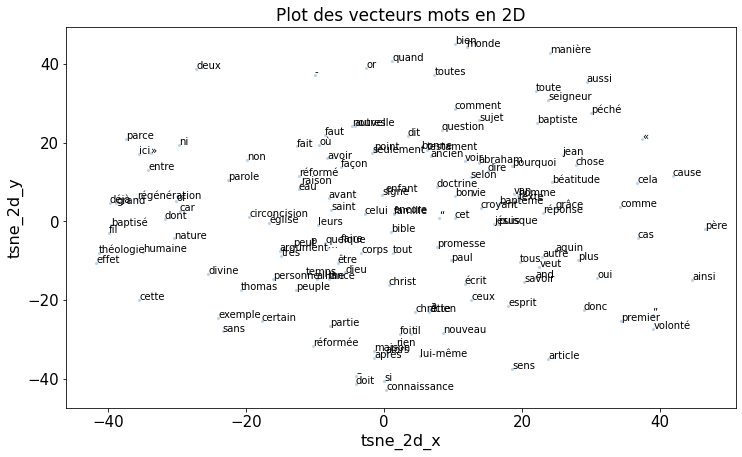

In [21]:
plot_word_vectors_2d(tsne_results, words_vectors_cbow.index_to_key, n_kept)

In [18]:
print(tsne_results[0:50:,0])

[-5.63936806e+00 -3.38010674e+01  3.74180756e+01  6.66318655e+00
  1.66961517e+01  3.42667618e+01 -6.68054008e+00  2.81218128e+01
 -9.78021812e+00 -3.54577370e+01 -1.26002884e+01  2.46274441e-01
 -3.11566424e-03  2.89382095e+01  3.44981790e+00  1.33715606e+00
  6.94114745e-01 -1.00610991e+01 -4.01476002e+00  2.34868217e+00
  1.03197765e+01  2.77739086e+01  3.67304497e+01 -1.31857176e+01
  1.93873043e+01 -1.98018131e+01  1.88134155e+01  2.93479309e+01
  3.96189475e+00  1.50003681e+01  2.37682705e+01 -8.08838844e+00
  1.96635494e+01  4.46193657e+01 -3.41949234e+01 -3.03748379e+01
 -1.20244055e+01  2.29443607e+01  8.40052700e+00 -3.74212227e+01
 -2.95773582e+01  4.65431099e+01 -1.95176926e+01 -6.27913332e+00
 -1.60643539e+01  2.48114300e+01 -2.33948288e+01 -1.66532173e+01
 -3.96096840e+01 -2.71804333e+01]


Utilisation des features word2vec pour la classification

Creation features du modele : moyenne des "mots" d'une phrase

In [19]:
vocab = model.wv.index_to_key
# len(vocab)
# type(vocab)
# print(vocab)
vocab=list(model.wv.key_to_index.keys())
# vocab
type(vocab)

list

In [20]:
words_vectors_cbow_cbow["alliance"] # vecteur des mots, indice par mot (string)

NameError: name 'words_vectors_cbow_cbow' is not defined

In [ ]:
words_vectors_cbow_cbow = model_cbow.wv
vocab = model_cbow.wv.index_to_key
corpus_average_vectors = []
sentence_average_vector = []
sentence_vectors = []
vector_space_dim = 200

for i in range(len(tokens)):
    sentence = tokens[i]
    sentence_words = list(set(vocab) & set(sentence))
    if(sentence_words != []):
        sentence_average_vector = np.mean(words_vectors_cbow_cbow[sentence_words], axis=0)
        # print("words_vectors_cbow_cbow[sentence_words] =", words_vectors_cbow_cbow[sentence_words])
    else:
        print("sentence =", sentence)
        print("sentence_words =", sentence_words)
        sentence_average_vector = np.zeros(vector_space_dim)
    corpus_average_vectors.append(sentence_average_vector)
# print("len(sentence_vectors) =", len(sentence_vectors))
# print("sentence_vectors =", sentence_vectors)
# print("len(sentence_average_vector) =", len(sentence_average_vector))
# len(corpus_average_vectors)
corpus_word2vec_sk = pd.DataFrame(corpus_average_vectors)
corpus_word2vec_sk['id'] = corpus['id']
corpus_word2vec_sk['message'] = corpus['message']
corpus_word2vec_sk["category_bin"] = corpus["category_bin"]
# corpus_word2vec_sk

sentence = ['tortarolohttpssecuregravatarcomavatarbaddffbdfaefbsdmmrg']
sentence_words = []
